# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import transforms
from skimage.metrics import structural_similarity

# import models
from src.model import MLP, VBMLP
# import basic training routine
from src.training import train
# import simple methods to access the gradient reconstruction algorithm of https://github.com/JonasGeiping/invertinggradients
from src.attack import get_gradient, gradient_inversion
#import some more utils
from src.utils import show_reconstructions

# Model Training

## Load CIFAR10 dataset

In [2]:
BATCH_SIZE = 64
DATAPATH = './data/'
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

CIFAR10_MEAN = [0.4914672374725342, 0.4822617471218109, 0.4467701315879822]
CIFAR10_STD = [0.24703224003314972, 0.24348513782024384, 0.26158785820007324]

dm = torch.as_tensor(CIFAR10_MEAN)[:, None, None].to(device)
ds = torch.as_tensor(CIFAR10_STD)[:, None, None].to(device)

transformations = transforms.Compose([transforms.ToTensor(), transforms.Normalize(dm, ds)])

trn_set = torchvision.datasets.CIFAR10(root=DATAPATH, train=True, download=True, transform=transformations)
tst_set = torchvision.datasets.CIFAR10(root=DATAPATH, train=False, download=True, transform=transformations)

trn_loader = torch.utils.data.DataLoader(trn_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
tst_loader = torch.utils.data.DataLoader(tst_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

Files already downloaded and verified
Files already downloaded and verified


## Training of basic MLP

In [3]:
EPOCHS = 300

mlp = MLP(num_classes=10, data_shape=(3,32,32)).to(device)
mlp_optimizer = torch.optim.Adam(mlp.parameters(), lr = 0.001)

mlp_metrics = train(mlp, mlp_optimizer, trn_loader, tst_loader, EPOCHS, False, device)

START TRAINING
Epoch   1: Accuracy_TRN: 0.45312 | CrossEntropy_TRN: 1.67339 | Accuracy_TST: 0.43750 | CrossEntropy_TST: 1.53800 
Epoch   2: Accuracy_TRN: 0.46875 | CrossEntropy_TRN: 1.47875 | Accuracy_TST: 0.50000 | CrossEntropy_TST: 1.48442 
Epoch   3: Accuracy_TRN: 0.48438 | CrossEntropy_TRN: 1.38338 | Accuracy_TST: 0.43750 | CrossEntropy_TST: 1.43358 
Epoch   4: Accuracy_TRN: 0.48438 | CrossEntropy_TRN: 1.29360 | Accuracy_TST: 0.43750 | CrossEntropy_TST: 1.44136 
Epoch   5: Accuracy_TRN: 0.57812 | CrossEntropy_TRN: 1.22217 | Accuracy_TST: 0.37500 | CrossEntropy_TST: 1.45466 
Epoch   6: Accuracy_TRN: 0.57812 | CrossEntropy_TRN: 1.16258 | Accuracy_TST: 0.56250 | CrossEntropy_TST: 1.45814 
Epoch   7: Accuracy_TRN: 0.57812 | CrossEntropy_TRN: 1.09528 | Accuracy_TST: 0.68750 | CrossEntropy_TST: 1.45219 
Epoch   8: Accuracy_TRN: 0.62500 | CrossEntropy_TRN: 1.03206 | Accuracy_TST: 0.43750 | CrossEntropy_TST: 1.50267 
Epoch   9: Accuracy_TRN: 0.43750 | CrossEntropy_TRN: 0.97630 | Accuracy_T

## Training of VBMLP (MLP with PRECODE)

In [4]:
vb_mlp = VBMLP(num_classes=10, data_shape=(3,32,32)).to(device)
vb_mlp_optimizer = torch.optim.Adam(vb_mlp.parameters(), lr = 0.001)

vb_mlp_metrics = train(vb_mlp, vb_mlp_optimizer, trn_loader, tst_loader, EPOCHS, True, device)

START TRAINING
Epoch   1: Accuracy_TRN: 0.37500 | CrossEntropy_TRN: 1.89382 | Accuracy_TST: 0.43750 | CrossEntropy_TST: 1.75449 
Epoch   2: Accuracy_TRN: 0.42188 | CrossEntropy_TRN: 1.71724 | Accuracy_TST: 0.31250 | CrossEntropy_TST: 1.68285 
Epoch   3: Accuracy_TRN: 0.45312 | CrossEntropy_TRN: 1.62474 | Accuracy_TST: 0.31250 | CrossEntropy_TST: 1.66349 
Epoch   4: Accuracy_TRN: 0.48438 | CrossEntropy_TRN: 1.54380 | Accuracy_TST: 0.56250 | CrossEntropy_TST: 1.59446 
Epoch   5: Accuracy_TRN: 0.48438 | CrossEntropy_TRN: 1.47448 | Accuracy_TST: 0.31250 | CrossEntropy_TST: 1.57793 
Epoch   6: Accuracy_TRN: 0.46875 | CrossEntropy_TRN: 1.40723 | Accuracy_TST: 0.31250 | CrossEntropy_TST: 1.55946 
Epoch   7: Accuracy_TRN: 0.54688 | CrossEntropy_TRN: 1.34760 | Accuracy_TST: 0.50000 | CrossEntropy_TST: 1.57701 
Epoch   8: Accuracy_TRN: 0.43750 | CrossEntropy_TRN: 1.29230 | Accuracy_TST: 0.43750 | CrossEntropy_TST: 1.54864 
Epoch   9: Accuracy_TRN: 0.48438 | CrossEntropy_TRN: 1.23959 | Accuracy_T

## Plots of training results
Both models achieve similar model performance.

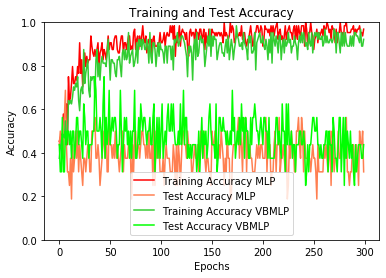

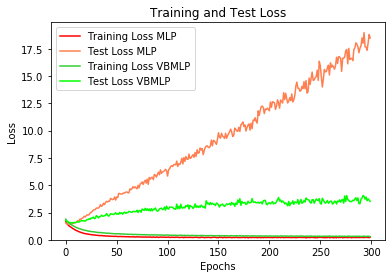

In [5]:
epochs = range(EPOCHS)

plt.plot(epochs, mlp_metrics['Accuracy_TRN'], 'red', label='Training Accuracy MLP')
plt.plot(epochs, mlp_metrics['Accuracy_TST'], 'coral', label='Test Accuracy MLP')
plt.plot(epochs, vb_mlp_metrics['Accuracy_TRN'], 'limegreen', label='Training Accuracy VBMLP')
plt.plot(epochs, vb_mlp_metrics['Accuracy_TST'], 'lime', label='Test Accuracy VBMLP')
plt.title('Training and Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.legend()
plt.show()
plt.close()

plt.plot(mlp_metrics['CrossEntropy_TRN'], 'red', label='Training Loss MLP')
plt.plot(mlp_metrics['CrossEntropy_TST'], 'coral', label='Test Loss MLP')
plt.plot(vb_mlp_metrics['CrossEntropy_TRN'], 'limegreen', label='Training Loss VBMLP')
plt.plot(vb_mlp_metrics['CrossEntropy_TST'], 'lime', label='Test Loss VBMLP')
plt.title('Training and Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0)
plt.legend()
plt.show()
plt.close()

# Test Privacy of untrained models

## Load victim data
Victim data consists of the 128 randomly sampled images and labels from the CIFAR10 training dataset that are attacked in the paper.

In [6]:
data = torch.load('data/128CIF_RECDATA.dict')['images'].to(device)
labels = torch.load('data/128CIF_RECDATA.dict')['labels'].to(device)
data_shape = data.shape[1:]

## Attack untrained MLP and VBMLP

It: 0. Rec. loss: 0.8514.
It: 500. Rec. loss: 0.0098.
It: 1000. Rec. loss: 0.0062.
It: 1500. Rec. loss: 0.0066.
It: 2000. Rec. loss: 0.0068.
It: 2500. Rec. loss: 0.0059.
It: 3000. Rec. loss: 0.0060.
It: 3500. Rec. loss: 0.0060.
It: 4000. Rec. loss: 0.0060.
It: 4500. Rec. loss: 0.0060.
It: 5000. Rec. loss: 0.0060.
It: 5500. Rec. loss: 0.0060.
It: 6000. Rec. loss: 0.0060.
It: 6500. Rec. loss: 0.0060.
It: 6999. Rec. loss: 0.0060.
Choosing optimal result ...
Optimal result score: 0.0060
Total time: 126.3368411064148.
It: 0. Rec. loss: 1.0176.
It: 500. Rec. loss: 0.5288.
It: 1000. Rec. loss: 0.6375.
It: 1500. Rec. loss: 0.5556.
It: 2000. Rec. loss: 0.5122.
It: 2500. Rec. loss: 0.5606.
It: 3000. Rec. loss: 0.5535.
It: 3500. Rec. loss: 0.5354.
It: 4000. Rec. loss: 0.5862.
It: 4500. Rec. loss: 0.5741.
It: 5000. Rec. loss: 0.6000.
It: 5500. Rec. loss: 0.5512.
It: 6000. Rec. loss: 0.5600.
It: 6500. Rec. loss: 0.5716.
It: 6999. Rec. loss: 0.5739.
Choosing optimal result ...
Optimal result score: 

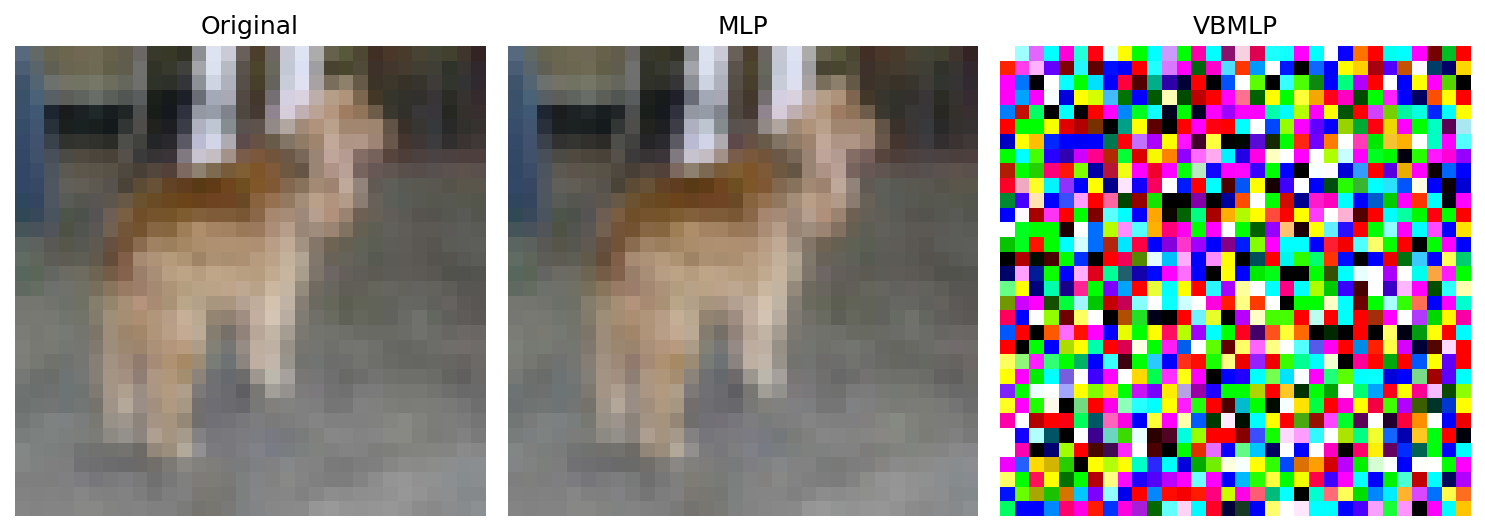

It: 0. Rec. loss: 0.8363.
It: 500. Rec. loss: 0.0034.
It: 1000. Rec. loss: 0.0033.
It: 1500. Rec. loss: 0.0034.
It: 2000. Rec. loss: 0.0039.
It: 2500. Rec. loss: 0.0034.
It: 3000. Rec. loss: 0.0033.
It: 3500. Rec. loss: 0.0033.
It: 4000. Rec. loss: 0.0033.
It: 4500. Rec. loss: 0.0033.
It: 5000. Rec. loss: 0.0033.
It: 5500. Rec. loss: 0.0033.
It: 6000. Rec. loss: 0.0033.
It: 6500. Rec. loss: 0.0033.
It: 6999. Rec. loss: 0.0033.
Choosing optimal result ...
Optimal result score: 0.0033
Total time: 127.76954174041748.
It: 0. Rec. loss: 0.9168.
It: 500. Rec. loss: 0.5721.
It: 1000. Rec. loss: 0.6068.
It: 1500. Rec. loss: 0.5578.
It: 2000. Rec. loss: 0.6012.
It: 2500. Rec. loss: 0.6207.
It: 3000. Rec. loss: 0.5677.
It: 3500. Rec. loss: 0.5558.
It: 4000. Rec. loss: 0.6523.
It: 4500. Rec. loss: 0.5735.
It: 5000. Rec. loss: 0.5982.
It: 5500. Rec. loss: 0.5161.
It: 6000. Rec. loss: 0.5938.
It: 6500. Rec. loss: 0.5861.
It: 6999. Rec. loss: 0.5599.
Choosing optimal result ...
Optimal result score:

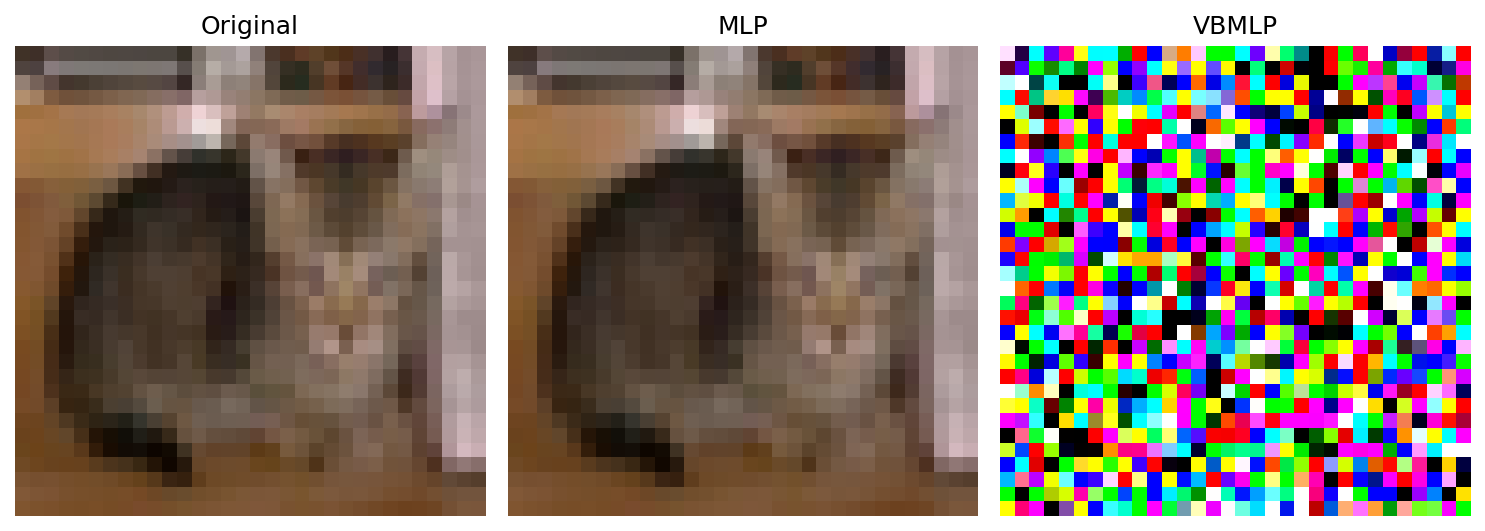

It: 0. Rec. loss: 0.8645.
It: 500. Rec. loss: 0.0015.
It: 1000. Rec. loss: 0.0022.
It: 1500. Rec. loss: 0.0003.
It: 2000. Rec. loss: 0.0007.
It: 2500. Rec. loss: 0.0009.
It: 3000. Rec. loss: 0.0003.
It: 3500. Rec. loss: 0.0003.
It: 4000. Rec. loss: 0.0003.
It: 4500. Rec. loss: 0.0003.
It: 5000. Rec. loss: 0.0003.
It: 5500. Rec. loss: 0.0003.
It: 6000. Rec. loss: 0.0003.
It: 6500. Rec. loss: 0.0003.
It: 6999. Rec. loss: 0.0003.
Choosing optimal result ...
Optimal result score: 0.0003
Total time: 125.78369903564453.
It: 0. Rec. loss: 0.9142.
It: 500. Rec. loss: 0.6448.
It: 1000. Rec. loss: 0.6041.
It: 1500. Rec. loss: 0.5633.
It: 2000. Rec. loss: 0.5842.
It: 2500. Rec. loss: 0.5521.
It: 3000. Rec. loss: 0.5432.
It: 3500. Rec. loss: 0.6413.
It: 4000. Rec. loss: 0.5861.
It: 4500. Rec. loss: 0.5450.
It: 5000. Rec. loss: 0.5318.
It: 5500. Rec. loss: 0.5684.
It: 6000. Rec. loss: 0.5964.
It: 6500. Rec. loss: 0.6066.
It: 6999. Rec. loss: 0.5095.
Choosing optimal result ...
Optimal result score:

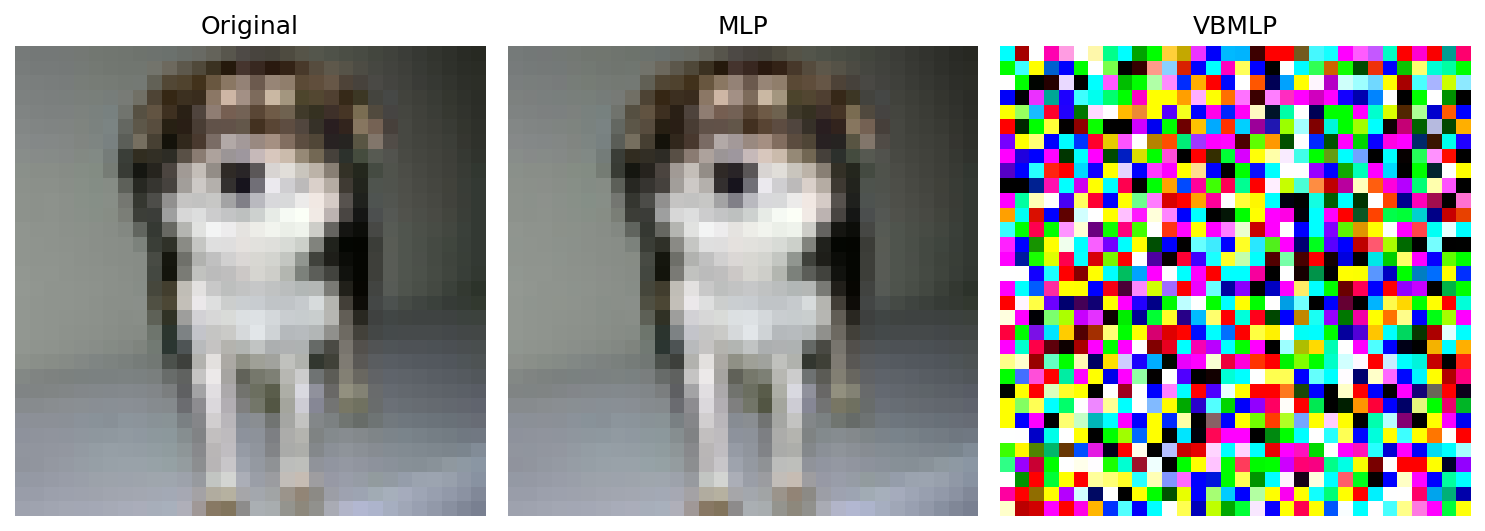

It: 0. Rec. loss: 0.8641.
It: 500. Rec. loss: 0.0000.
It: 1000. Rec. loss: 0.0000.
It: 1500. Rec. loss: 0.0000.
It: 2000. Rec. loss: 0.0000.
It: 2500. Rec. loss: 0.0000.
It: 3000. Rec. loss: 0.0000.
It: 3500. Rec. loss: 0.0000.
It: 4000. Rec. loss: 0.0000.
It: 4500. Rec. loss: 0.0000.
It: 5000. Rec. loss: 0.0000.
It: 5500. Rec. loss: 0.0000.
It: 6000. Rec. loss: 0.0000.
It: 6500. Rec. loss: 0.0000.
It: 6999. Rec. loss: 0.0000.
Choosing optimal result ...
Optimal result score: 0.0000
Total time: 127.59179282188416.
It: 0. Rec. loss: 1.0341.
It: 500. Rec. loss: 0.6192.
It: 1000. Rec. loss: 0.5739.
It: 1500. Rec. loss: 0.5258.
It: 2000. Rec. loss: 0.5853.
It: 2500. Rec. loss: 0.5598.
It: 3000. Rec. loss: 0.6059.
It: 3500. Rec. loss: 0.5200.
It: 4000. Rec. loss: 0.5958.
It: 4500. Rec. loss: 0.5771.
It: 5000. Rec. loss: 0.5744.
It: 5500. Rec. loss: 0.5640.
It: 6000. Rec. loss: 0.4973.
It: 6500. Rec. loss: 0.5821.
It: 6999. Rec. loss: 0.5232.
Choosing optimal result ...
Optimal result score:

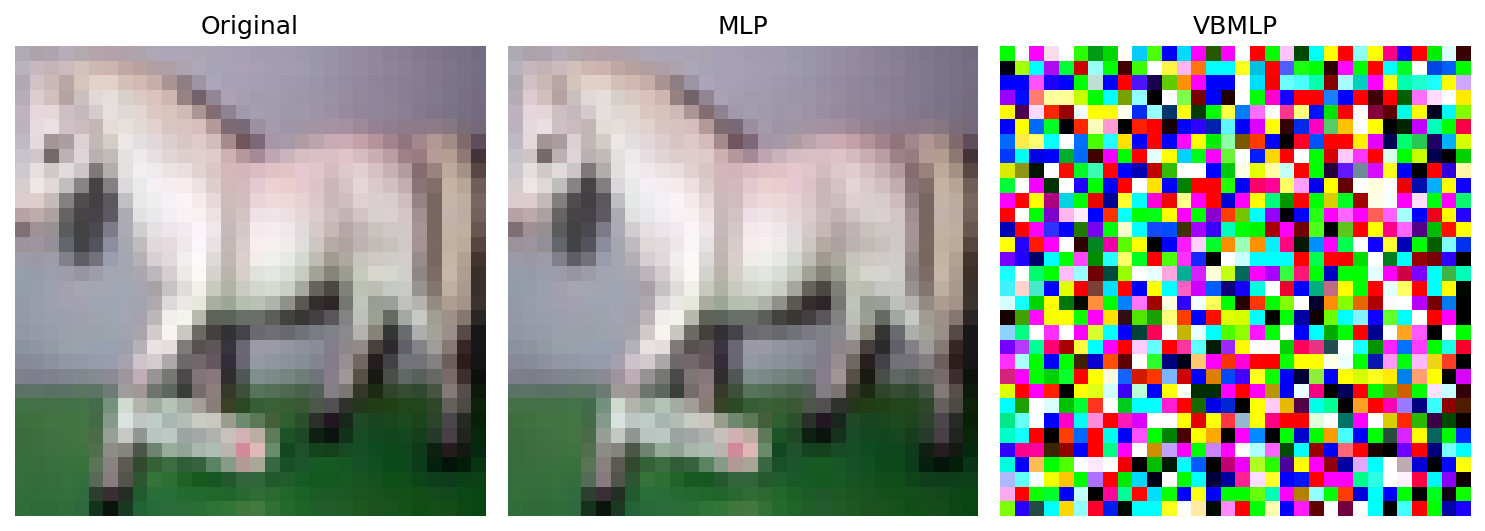

It: 0. Rec. loss: 0.8355.
It: 500. Rec. loss: 0.0004.
It: 1000. Rec. loss: 0.0051.
It: 1500. Rec. loss: 0.0057.
It: 2000. Rec. loss: 0.0024.
It: 2500. Rec. loss: 0.0047.
It: 3000. Rec. loss: 0.0031.
It: 3500. Rec. loss: 0.0031.
It: 4000. Rec. loss: 0.0040.
It: 4500. Rec. loss: 0.0045.
It: 5000. Rec. loss: 0.0029.
It: 5500. Rec. loss: 0.0031.
It: 6000. Rec. loss: 0.0040.
It: 6500. Rec. loss: 0.0029.
It: 6999. Rec. loss: 0.0040.
Choosing optimal result ...
Optimal result score: 0.0040
Total time: 124.32986187934875.
It: 0. Rec. loss: 0.9801.
It: 500. Rec. loss: 0.5654.
It: 1000. Rec. loss: 0.5961.
It: 1500. Rec. loss: 0.5544.
It: 2000. Rec. loss: 0.5525.
It: 2500. Rec. loss: 0.5531.
It: 3000. Rec. loss: 0.5643.
It: 3500. Rec. loss: 0.5566.
It: 4000. Rec. loss: 0.5270.
It: 4500. Rec. loss: 0.5985.
It: 5000. Rec. loss: 0.5346.
It: 5500. Rec. loss: 0.4695.
It: 6000. Rec. loss: 0.5936.
It: 6500. Rec. loss: 0.6048.
It: 6999. Rec. loss: 0.6313.
Choosing optimal result ...
Optimal result score:

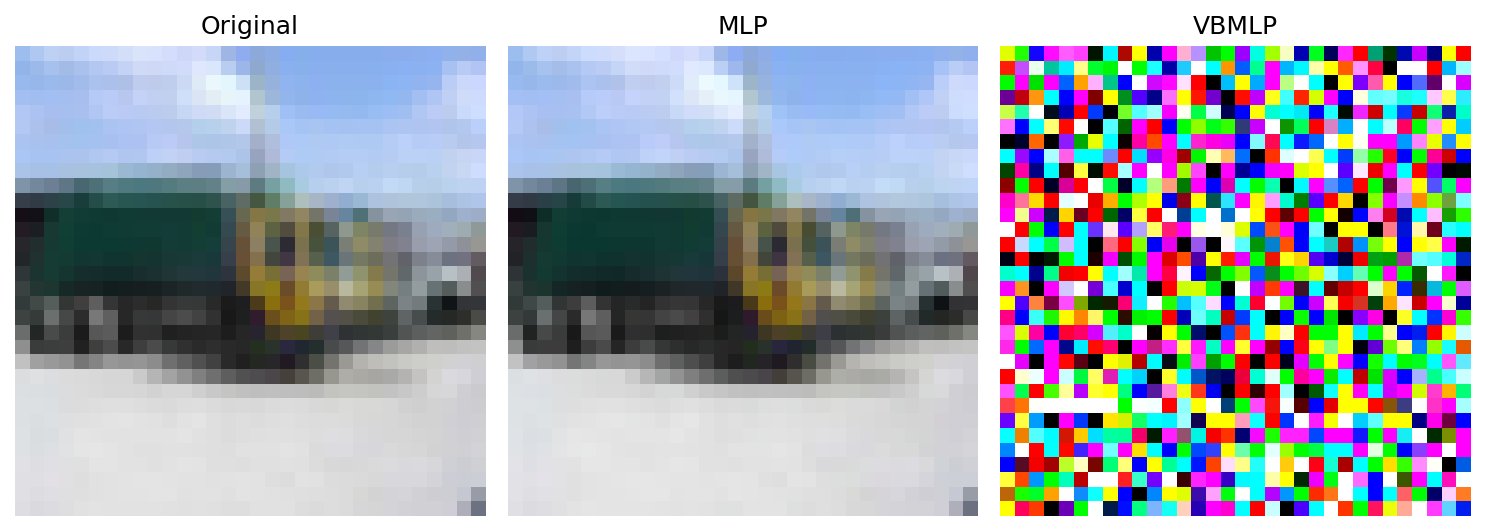

It: 0. Rec. loss: 0.8539.
It: 500. Rec. loss: 0.0024.
It: 1000. Rec. loss: 0.0035.
It: 1500. Rec. loss: 0.0027.
It: 2000. Rec. loss: 0.0025.
It: 2500. Rec. loss: 0.0024.
It: 3000. Rec. loss: 0.0023.
It: 3500. Rec. loss: 0.0023.
It: 4000. Rec. loss: 0.0024.
It: 4500. Rec. loss: 0.0023.
It: 5000. Rec. loss: 0.0023.
It: 5500. Rec. loss: 0.0023.
It: 6000. Rec. loss: 0.0023.
It: 6500. Rec. loss: 0.0023.
It: 6999. Rec. loss: 0.0023.
Choosing optimal result ...
Optimal result score: 0.0023
Total time: 125.6665985584259.
It: 0. Rec. loss: 1.0827.
It: 500. Rec. loss: 0.5496.
It: 1000. Rec. loss: 0.5418.
It: 1500. Rec. loss: 0.6477.
It: 2000. Rec. loss: 0.5535.
It: 2500. Rec. loss: 0.5756.
It: 3000. Rec. loss: 0.5777.
It: 3500. Rec. loss: 0.5236.
It: 4000. Rec. loss: 0.5531.
It: 4500. Rec. loss: 0.5964.
It: 5000. Rec. loss: 0.5696.
It: 5500. Rec. loss: 0.5567.
It: 6000. Rec. loss: 0.5346.
It: 6500. Rec. loss: 0.6323.
It: 6999. Rec. loss: 0.5613.
Choosing optimal result ...
Optimal result score: 

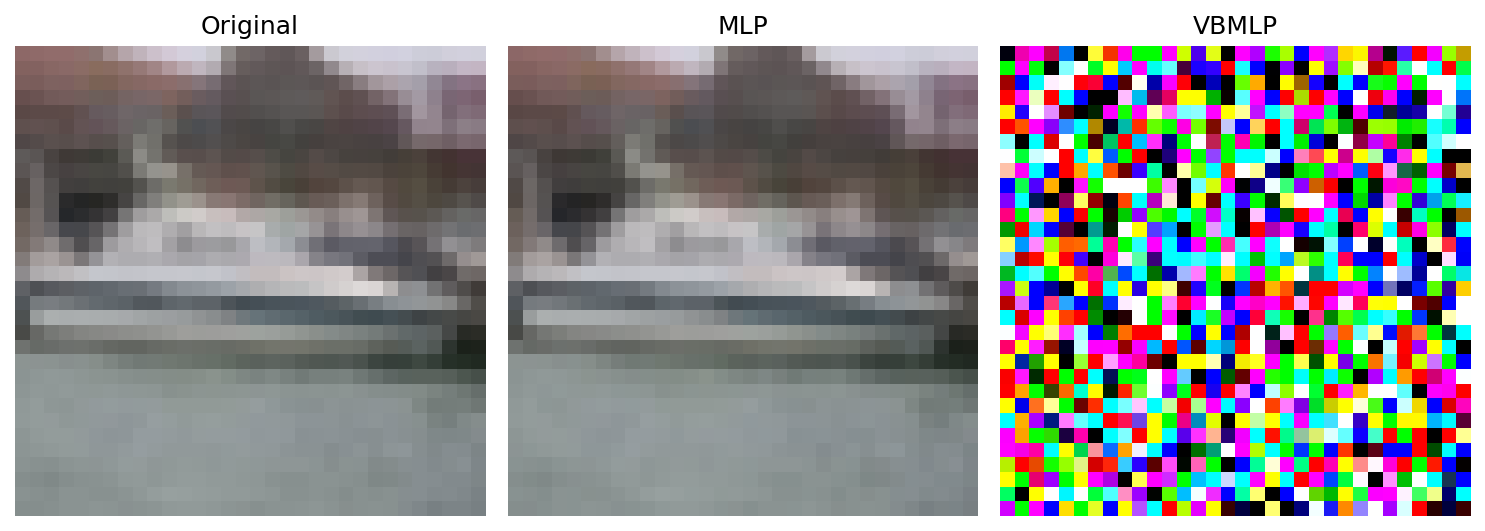

It: 0. Rec. loss: 0.8510.
It: 500. Rec. loss: 0.0098.
It: 1000. Rec. loss: 0.0090.
It: 1500. Rec. loss: 0.0090.
It: 2000. Rec. loss: 0.0138.
It: 2500. Rec. loss: 0.0089.
It: 3000. Rec. loss: 0.0095.
It: 3500. Rec. loss: 0.0101.
It: 4000. Rec. loss: 0.0089.
It: 4500. Rec. loss: 0.0101.
It: 5000. Rec. loss: 0.0101.
It: 5500. Rec. loss: 0.0102.
It: 6000. Rec. loss: 0.0101.
It: 6500. Rec. loss: 0.0089.
It: 6999. Rec. loss: 0.0089.
Choosing optimal result ...
Optimal result score: 0.0089
Total time: 126.14183855056763.
It: 0. Rec. loss: 0.9925.
It: 500. Rec. loss: 0.5189.
It: 1000. Rec. loss: 0.5587.
It: 1500. Rec. loss: 0.5082.
It: 2000. Rec. loss: 0.5556.
It: 2500. Rec. loss: 0.5569.
It: 3000. Rec. loss: 0.5804.
It: 3500. Rec. loss: 0.5511.
It: 4000. Rec. loss: 0.5918.
It: 4500. Rec. loss: 0.5917.
It: 5000. Rec. loss: 0.5447.
It: 5500. Rec. loss: 0.6025.
It: 6000. Rec. loss: 0.5920.
It: 6500. Rec. loss: 0.5417.
It: 6999. Rec. loss: 0.5672.
Choosing optimal result ...
Optimal result score:

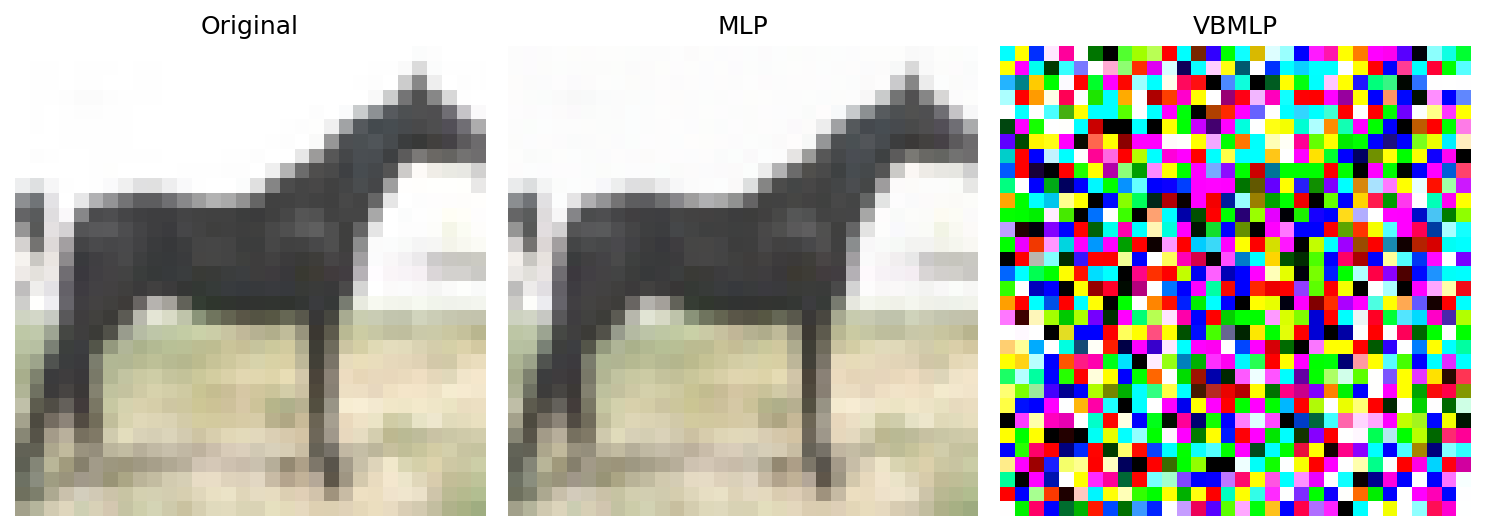

It: 0. Rec. loss: 0.8596.
It: 500. Rec. loss: 0.0102.
It: 1000. Rec. loss: 0.0087.
It: 1500. Rec. loss: 0.0015.
It: 2000. Rec. loss: 0.0020.
It: 2500. Rec. loss: 0.0019.
It: 3000. Rec. loss: 0.0016.
It: 3500. Rec. loss: 0.0016.
It: 4000. Rec. loss: 0.0015.
It: 4500. Rec. loss: 0.0015.
It: 5000. Rec. loss: 0.0015.
It: 5500. Rec. loss: 0.0015.
It: 6000. Rec. loss: 0.0015.
It: 6500. Rec. loss: 0.0015.
It: 6999. Rec. loss: 0.0015.
Choosing optimal result ...
Optimal result score: 0.0015
Total time: 122.6862645149231.
It: 0. Rec. loss: 0.9099.
It: 500. Rec. loss: 0.6666.
It: 1000. Rec. loss: 0.6509.
It: 1500. Rec. loss: 0.6238.
It: 2000. Rec. loss: 0.6467.
It: 2500. Rec. loss: 0.5546.
It: 3000. Rec. loss: 0.6309.
It: 3500. Rec. loss: 0.5892.
It: 4000. Rec. loss: 0.5792.
It: 4500. Rec. loss: 0.5961.
It: 5000. Rec. loss: 0.6280.
It: 5500. Rec. loss: 0.5464.
It: 6000. Rec. loss: 0.5841.
It: 6500. Rec. loss: 0.6086.
It: 6999. Rec. loss: 0.5752.
Choosing optimal result ...
Optimal result score: 

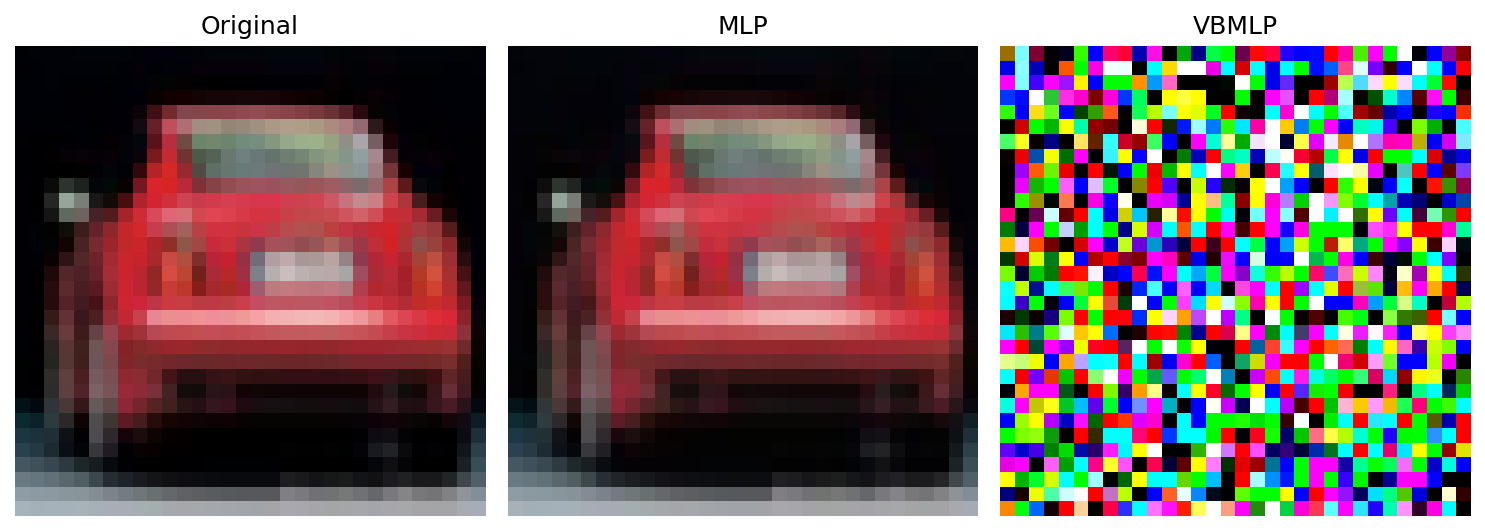

It: 0. Rec. loss: 0.8391.
It: 500. Rec. loss: 0.0049.
It: 1000. Rec. loss: 0.0011.
It: 1500. Rec. loss: 0.0001.
It: 2000. Rec. loss: 0.0021.
It: 2500. Rec. loss: 0.0029.
It: 3000. Rec. loss: 0.0000.
It: 3500. Rec. loss: 0.0000.
It: 4000. Rec. loss: 0.0000.
It: 4500. Rec. loss: 0.0000.
It: 5000. Rec. loss: 0.0000.
It: 5500. Rec. loss: 0.0000.
It: 6000. Rec. loss: 0.0000.
It: 6500. Rec. loss: 0.0000.
It: 6999. Rec. loss: 0.0000.
Choosing optimal result ...
Optimal result score: 0.0000
Total time: 126.2663185596466.
It: 0. Rec. loss: 0.8897.
It: 500. Rec. loss: 0.5728.
It: 1000. Rec. loss: 0.5802.
It: 1500. Rec. loss: 0.5888.
It: 2000. Rec. loss: 0.5775.
It: 2500. Rec. loss: 0.6774.
It: 3000. Rec. loss: 0.5901.
It: 3500. Rec. loss: 0.5472.
It: 4000. Rec. loss: 0.5866.
It: 4500. Rec. loss: 0.6077.
It: 5000. Rec. loss: 0.5402.
It: 5500. Rec. loss: 0.5657.
It: 6000. Rec. loss: 0.5655.
It: 6500. Rec. loss: 0.6060.
It: 6999. Rec. loss: 0.5971.
Choosing optimal result ...
Optimal result score: 

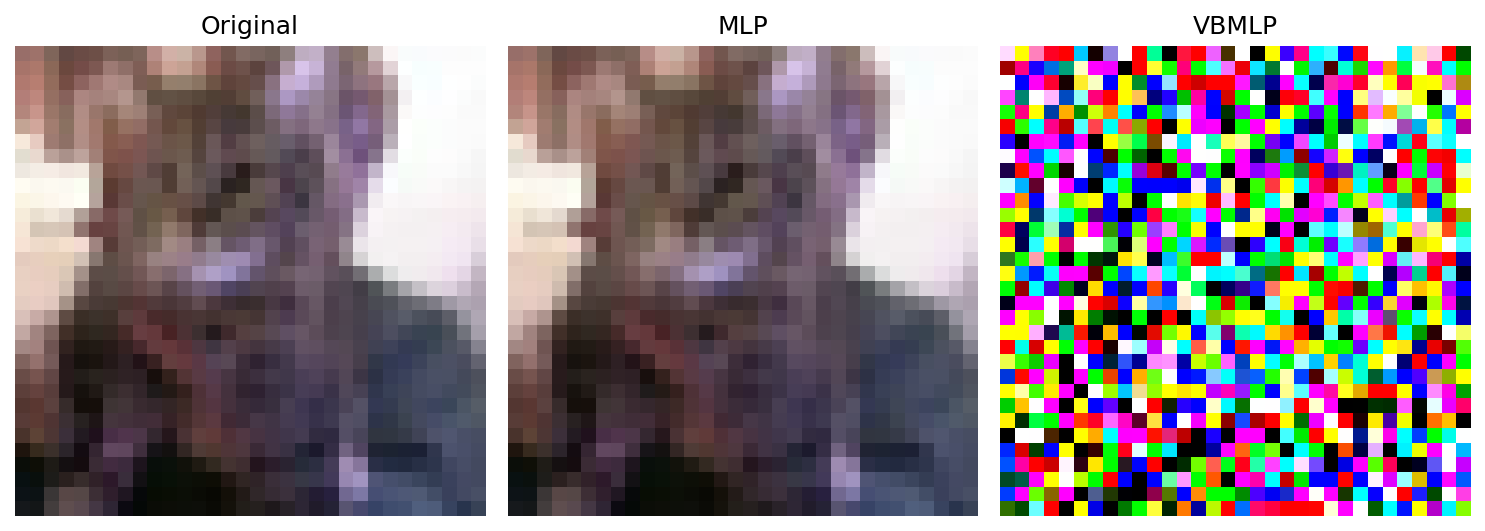

It: 0. Rec. loss: 0.8484.
It: 500. Rec. loss: 0.0014.
It: 1000. Rec. loss: 0.0021.
It: 1500. Rec. loss: 0.0011.
It: 2000. Rec. loss: 0.0022.
It: 2500. Rec. loss: 0.0032.
It: 3000. Rec. loss: 0.0035.
It: 3500. Rec. loss: 0.0030.
It: 4000. Rec. loss: 0.0035.
It: 4500. Rec. loss: 0.0033.
It: 5000. Rec. loss: 0.0033.
It: 5500. Rec. loss: 0.0030.
It: 6000. Rec. loss: 0.0030.
It: 6500. Rec. loss: 0.0028.
It: 6999. Rec. loss: 0.0028.
Choosing optimal result ...
Optimal result score: 0.0030
Total time: 123.7140896320343.
It: 0. Rec. loss: 1.0022.
It: 500. Rec. loss: 0.5819.
It: 1000. Rec. loss: 0.5911.
It: 1500. Rec. loss: 0.6032.
It: 2000. Rec. loss: 0.5451.
It: 2500. Rec. loss: 0.6144.
It: 3000. Rec. loss: 0.5745.
It: 3500. Rec. loss: 0.5449.
It: 4000. Rec. loss: 0.5805.
It: 4500. Rec. loss: 0.5549.
It: 5000. Rec. loss: 0.5591.
It: 5500. Rec. loss: 0.5332.
It: 6000. Rec. loss: 0.5096.
It: 6500. Rec. loss: 0.5647.
It: 6999. Rec. loss: 0.6429.
Choosing optimal result ...
Optimal result score: 

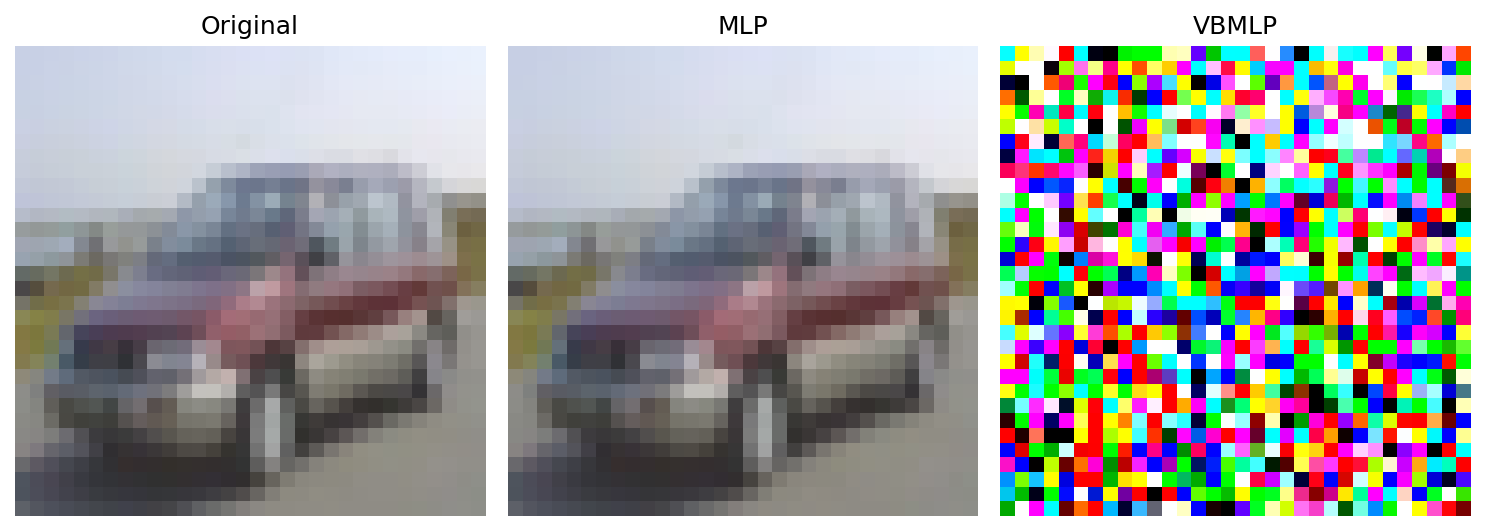

In [7]:
NUM_IMGS_TO_ATTACK = 10

mlp = MLP(num_classes=10, data_shape=data_shape).to(device)
vb_mlp = VBMLP(num_classes=10, data_shape=data_shape).to(device)

#build inversefed library specific config for the reconstruction attack
config = dict(signed=True,
            boxed=True,
            cost_fn='sim',
            indices='def',
            weights='equal',
            lr=0.01,
            optim='adam',
            restarts=1,
            max_iterations=7000,
            total_variation=1e-6,
            init='randn',
            filter='none',
            lr_decay=True,
            scoring_choice='loss',
            )

reconstructed_images_mlp = []
reconstructed_images_vb_mlp = []
ssims_mlp = []
ssims_vb_mlp = []
for i, (image, label) in enumerate(zip(data, labels)):
    label = label.unsqueeze(0)
    mlp_gradient = get_gradient(mlp, image.unsqueeze(0), label, False, True)
    vb_mlp_gradient = get_gradient(vb_mlp, image.unsqueeze(0), label, True, True)

    mlp_output_reconstruction = gradient_inversion(mlp_gradient, label, mlp, data_shape, dm, ds, config).squeeze()
    reconstructed_images_mlp.append(mlp_output_reconstruction)
    ssim_mlp = structural_similarity(image.permute((1,2,0)).cpu().numpy(), mlp_output_reconstruction.permute((1,2,0)).cpu().numpy(), multichannel=True)
    ssims_mlp.append(max(0, ssim_mlp))

    vb_mlp_output_reconstruction = gradient_inversion(vb_mlp_gradient, label, vb_mlp, data_shape, dm, ds, config).squeeze()
    reconstructed_images_vb_mlp.append(vb_mlp_output_reconstruction)
    ssim_vb_mlp = structural_similarity(image.permute((1,2,0)).cpu().numpy(), vb_mlp_output_reconstruction.permute((1,2,0)).cpu().numpy(), multichannel=True)
    ssims_vb_mlp.append(max(0, ssim_vb_mlp))

    print(f'Image {i:3}: SSIM MLP {ssim_mlp:.5f} | SSIM VBMLP {ssim_vb_mlp:.5f}')
    show_reconstructions([image, mlp_output_reconstruction, vb_mlp_output_reconstruction], dm, ds)
    
    if i == NUM_IMGS_TO_ATTACK-1:
        break   

## Summary of attack results

Mean SSIM for reconstructions MLP: 0.99969 | VBMLP: 0.00450


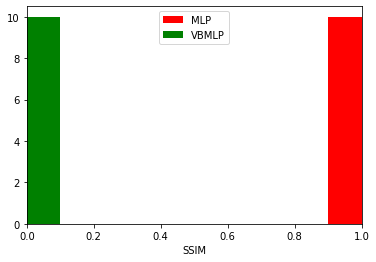

In [8]:
print(f'Mean SSIM for reconstructions MLP: {np.mean(ssims_mlp):.5f} | VBMLP: {np.mean(ssims_vb_mlp):.5f}')
plt.hist(ssims_mlp, color='r', bins=[x/10 for x in range(11)], label='MLP')
plt.hist(ssims_vb_mlp, color='g', bins=[x/10 for x in range(11)], label='VBMLP')
plt.xlabel('SSIM')
plt.xlim(0,1)
plt.legend(loc='upper center')
plt.show()
plt.close()